# Auto Insurance Case Study: Claims Risk Assessment

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearnex import patch_sklearn 
patch_sklearn()
from sklearn import preprocessing
from sklearn.model_selection import train_test_split,\
StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, plot_roc_curve,roc_auc_score,f1_score
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE
from yellowbrick.classifier import confusion_matrix, classification_report, ROCAUC
from yellowbrick.model_selection import CVScores
from clean_eda_helper import show_values, std_num_cols, rb_scale_cols, model_results, get_confusion_matrix\
,new_feat_2018, na_replace 
plt.style.use('ggplot')
import warnings
warnings.filterwarnings("ignore")

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


### # Loading datasets, and looking at shapes:-

In [2]:
# Loading datasets

train_df = pd.read_csv("clean_train.csv",index_col=0)
test_df = pd.read_csv("clean_test.csv",index_col=0)

# Looking at dataset shapes

print('Shape of original train data :',train_df.shape)
print('Shape of original test data :',test_df.shape)

Shape of original train data : (60386, 10)
Shape of original test data : (7462, 9)


### # Separating independant and dependant variables:-

In [3]:
## Separating x and y variables for test train split

LGBM_x = train_df.drop(['claim_risk_cat'], axis=1)
LGBM_y = train_df['claim_risk_cat']

In [4]:
LGBM_y # 1: Low credit risk: 1; High Credit risk: 0

0        1
1        0
2        0
3        1
4        0
        ..
60387    1
60388    1
60389    1
60390    1
60391    1
Name: claim_risk_cat, Length: 60386, dtype: int64

In [5]:
LGBM_y.value_counts(normalize=True)*100 # Imbalanced classes

1    83.39847
0    16.60153
Name: claim_risk_cat, dtype: float64

### # Train-Test split:

In [6]:
# Train test 70:30 split

trainX, testX, trainY, testY = train_test_split(LGBM_x, LGBM_y, random_state=42,\
                                                shuffle=True, stratify=LGBM_y, test_size=0.3)

# Looking at dataset shapes

print('\n')
print('Shape of imbalanced trainX data :',trainX.shape)
print('Shape of imbalanced trainY data :',trainY.shape)
print('Shape of imbalanced testX data :',testX.shape)
print('Shape of imbalanced testY data :',testY.shape)
print('\n')
print("*"*60)

# Looking at class ratios

print('\n')
print('Class ratio - Low Credit Risk/High Credit Risk (trainY) :',trainY.value_counts(normalize=True)*100)
print('Class ratio - Low Credit Risk/High Credit Risk (testY) :',testY.value_counts(normalize=True)*100)
print('\n')
print("*"*60)



Shape of imbalanced trainX data : (42270, 9)
Shape of imbalanced trainY data : (42270,)
Shape of imbalanced testX data : (18116, 9)
Shape of imbalanced testY data : (18116,)


************************************************************


Class ratio - Low Credit Risk/High Credit Risk (trainY) : 1    83.399574
0    16.600426
dtype: float64
Class ratio - Low Credit Risk/High Credit Risk (testY) : 1    83.395893
0    16.604107
dtype: float64


************************************************************


### # SMOTE Upsampling:

In [7]:
# Upsampling the minority class via SMOTE

trainX_SM, trainY_SM = SMOTE(random_state=0, k_neighbors=7).fit_resample(trainX, trainY)
testX_SM, testY_SM = SMOTE(random_state=0, k_neighbors=7).fit_resample(testX, testY)

# Looking at dataset shapes

print('\n')
print('Shape of SMOTE balanced trainX data :',trainX_SM.shape)
print('Shape of SMOTE balanced trainY data :',trainY_SM.shape)
print('Shape of SMOTE balanced testX data :',testX_SM.shape)
print('Shape of SMOTE balanced testY data :',testY_SM.shape)
print('\n')
print("*"*60)

# Looking at class ratios

print('\n')
print('Class ratio - Fraud/Non-Fraud (trainY_SM) :',trainY_SM.value_counts(normalize=True)*100)
print('Class ratio - Fraud/Non-Fraud (testY_SM) :',testY_SM.value_counts(normalize=True)*100)
print('\n')
print("*"*60)



Shape of SMOTE balanced trainX data : (70506, 9)
Shape of SMOTE balanced trainY data : (70506,)
Shape of SMOTE balanced testX data : (30216, 9)
Shape of SMOTE balanced testY data : (30216,)


************************************************************


Class ratio - Fraud/Non-Fraud (trainY_SM) : 0    50.0
1    50.0
dtype: float64
Class ratio - Fraud/Non-Fraud (testY_SM) : 0    50.0
1    50.0
dtype: float64


************************************************************


### # Standardizing/Robust Scaling the train/test features for base SMOTE Balanced Dataset:

In [8]:
# SMOTE balanced dataset

rb_scale_cols(trainX_SM)
rb_scale_cols(testX_SM)

### Baseline LightGBM Classifier Model - Robust Scaled:

In [9]:
# SMOTE Balanced

lgbm_sm = lgb.LGBMClassifier()
model_results(trainX_SM, trainY_SM, testX_SM, testY_SM, lgbm_sm, show = True)

The Model Results for  LGBMClassifier()
************************************************************
Train Accuracy is equal to 0.865
Test Accuracy is equal to 0.861
The Precision score is 0.831
The Average Precision score is 0.800
The Recall score is 0.905
The F1 score is 0.867
The AUC/ROC score is 0.861
True-Positive: 13671.000
True-Negative: 12335.000
False-Positive: 2773.000
False-Negative: 1437.000
Correctly Classified: 26006.000
Incorrectly Classified: 4210.000


[0.8651887782600063,
 0.8606698437913688,
 0.8313670639747021,
 0.9048848292295473]

## Using RandomizedSearchCV to select best parameters for SM dataset:

In [10]:
# Setting x and y variables

tr_x = trainX_SM
tr_y = trainY_SM
ts_x = testX_SM
ts_y = testY_SM

# Setting up xgb_sm model

lbg_bsm = lgb.LGBMClassifier()

# Setting the parameter grid

grid_para_lgb = [{
    "n_estimators": [110,120,130],
    "max_depth": [6,6.5,7],
    "learning_rate": np.linspace(1e-2,1,20),
    "colsample_bytree" : [0.5,0.7,1,1.2],
    "subsample": [0.6,0.8,1,1.2],
    "num_leaves" : [100,125,150,175]}]

# Running the XGB model through the grid search

grid_search_lgb = RandomizedSearchCV(lbg_bsm, grid_para_lgb,\
                                     cv=5,scoring='f1_weighted',verbose=1,\
                                     return_train_score = True, n_jobs=-1)

grid_search_lgb.fit(tr_x, tr_y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=LGBMClassifier(), n_jobs=-1,
                   param_distributions=[{'colsample_bytree': [0.5, 0.7, 1, 1.2],
                                         'learning_rate': array([0.01      , 0.06210526, 0.11421053, 0.16631579, 0.21842105,
       0.27052632, 0.32263158, 0.37473684, 0.42684211, 0.47894737,
       0.53105263, 0.58315789, 0.63526316, 0.68736842, 0.73947368,
       0.79157895, 0.84368421, 0.89578947, 0.94789474, 1.        ]),
                                         'max_depth': [6, 6.5, 7],
                                         'n_estimators': [110, 120, 130],
                                         'num_leaves': [100, 125, 150, 175],
                                         'subsample': [0.6, 0.8, 1, 1.2]}],
                   return_train_score=True, scoring='f1_weighted', verbose=1)

In [11]:
# The best parameters:

grid_search_lgb.best_params_

{'subsample': 1,
 'num_leaves': 150,
 'n_estimators': 120,
 'max_depth': 7,
 'learning_rate': 0.37473684210526315,
 'colsample_bytree': 0.5}

In [12]:
# The best score

grid_search_lgb.best_score_

0.838044758419376

In [13]:
# Best estimator training/test errors

print("The training error is: %.5f" % (1 - grid_search_lgb.best_estimator_.score(tr_x, tr_y)))
print("The test     error is: %.5f" % (1 - grid_search_lgb.best_estimator_.score(ts_x, ts_y)))

The training error is: 0.07609
The test     error is: 0.13655


### # Selecting the best model from the Grid Search as the final XGB SM model:

In [14]:
lgb_sm = lgb.LGBMClassifier(subsample=0.8, n_estimators=130, num_leaves=175,\
                      max_depth=7, learning_rate=0.427, colsample_bytree=0.5)
model_results(trainX_SM, trainY_SM, testX_SM, testY_SM, lgb_sm, show = True)

The Model Results for  LGBMClassifier(colsample_bytree=0.5, learning_rate=0.427, max_depth=7,
               n_estimators=130, num_leaves=175, subsample=0.8)
************************************************************
Train Accuracy is equal to 0.933
Test Accuracy is equal to 0.859
The Precision score is 0.826
The Average Precision score is 0.796
The Recall score is 0.909
The F1 score is 0.865
The AUC/ROC score is 0.859
True-Positive: 13732.000
True-Negative: 12214.000
False-Positive: 2894.000
False-Negative: 1376.000
Correctly Classified: 25946.000
Incorrectly Classified: 4270.000


[0.9325589311547954,
 0.8586841408525284,
 0.8259352820882955,
 0.9089224252051893]

### # Model metrics:

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

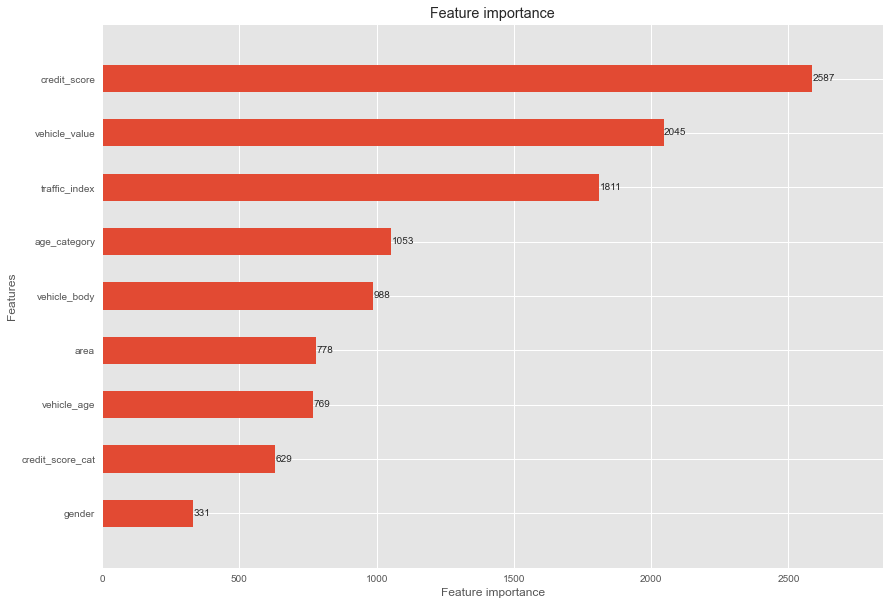

In [15]:
lgb.plot_importance(lgb_sm,height=.5,max_num_features=10,figsize=(14,10))

### # Full set of evaluation metrics for both models:

- Confusion matrix

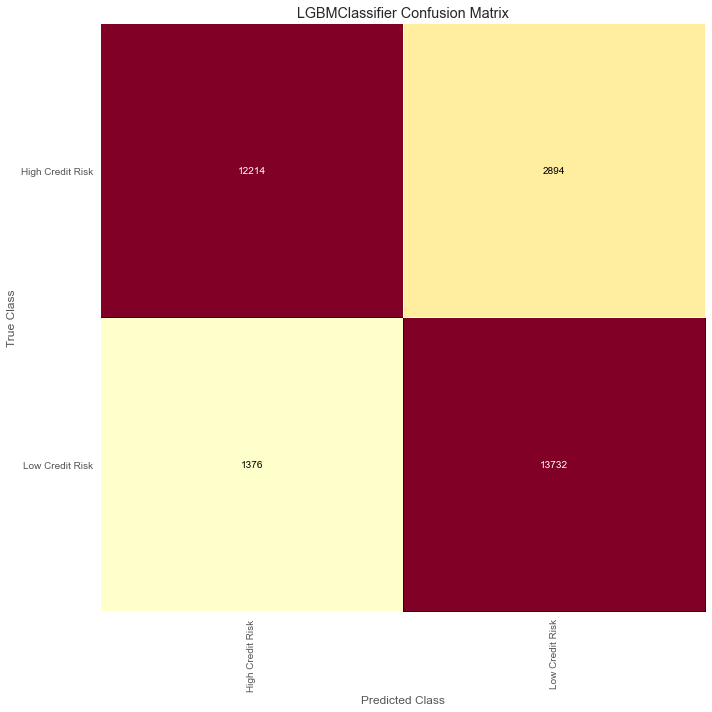

<AxesSubplot:title={'center':'LGBMClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [16]:
# Visualizing the confusion matrix with Yellowbricks (thres=0.5)

plt.figure(figsize = (10,10))
visualizer = confusion_matrix(
    lgb_sm,
    trainX_SM, trainY_SM, testX_SM, testY_SM,
    classes=['High Credit Risk', 'Low Credit Risk'])

visualizer.show()

- AUC/ROC curve

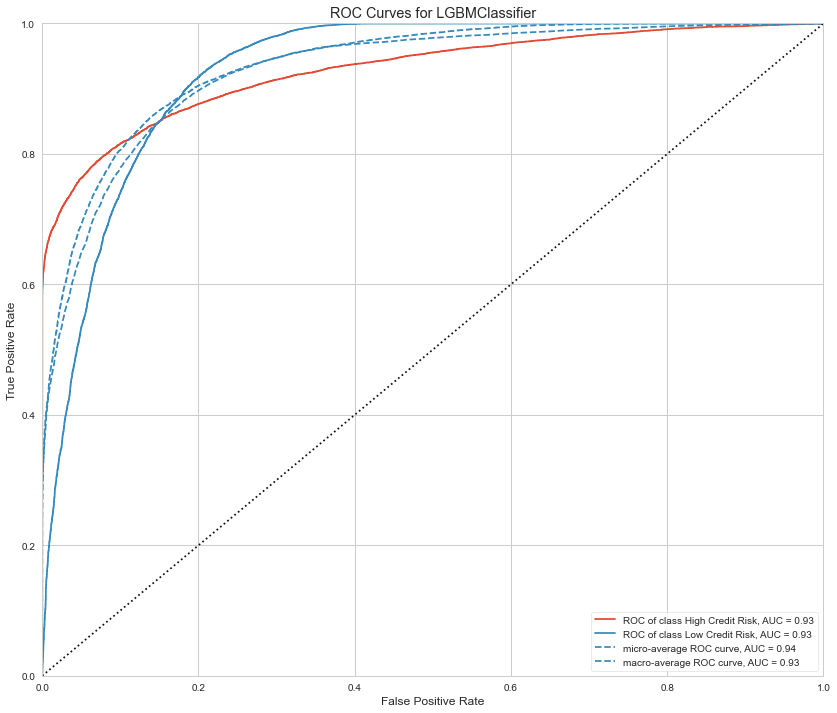

<AxesSubplot:title={'center':'ROC Curves for LGBMClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [17]:
# Visualizing the AUC/ROC curve with Yellowbricks

plt.figure(figsize = (14,12))
sns.set_style("whitegrid")

visualizer = ROCAUC(lgb_sm, classes=['High Credit Risk', 'Low Credit Risk'])

visualizer.fit(trainX_SM, trainY_SM)        # Fit the training data to the visualizer
visualizer.score(testX_SM, testY_SM)        # Evaluate the model on the test data

visualizer.show()

- Classification report

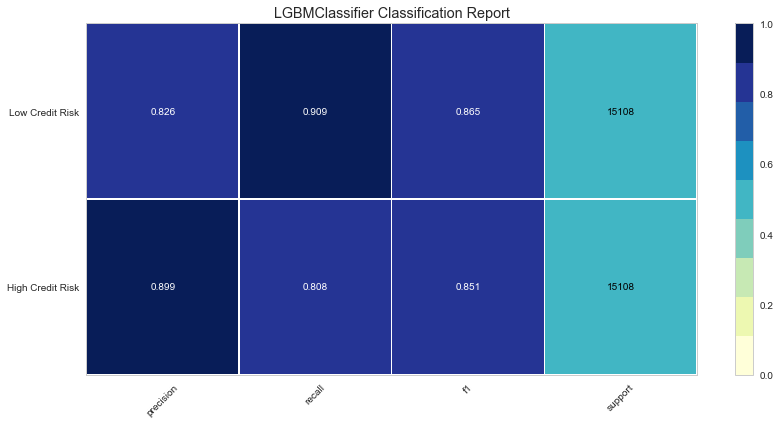

<AxesSubplot:title={'center':'LGBMClassifier Classification Report'}>

In [18]:
# Visualizing the classification report with Yellowbricks

plt.figure(figsize = (12,6))
sns.set_style("whitegrid")

visualizer = classification_report(
    lgb_sm,
    trainX_SM , trainY_SM, testX_SM , testY_SM,
    classes=['High Credit Risk', 'Low Credit Risk'],
    cmap='YlGnBu',
    support=True)

visualizer.show()

- Precision-recall curve

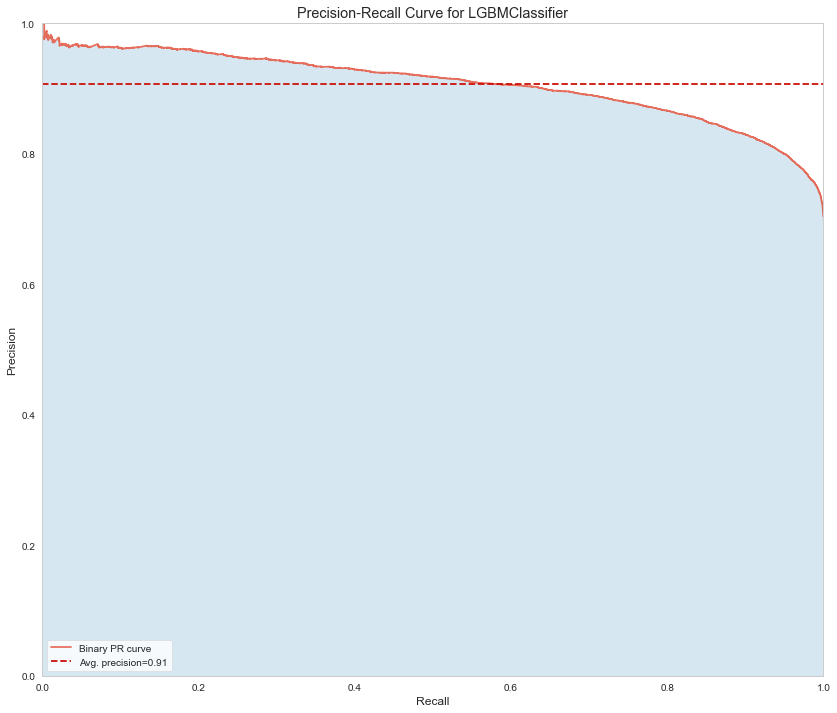

<AxesSubplot:title={'center':'Precision-Recall Curve for LGBMClassifier'}, xlabel='Recall', ylabel='Precision'>

In [19]:
# Visualizing precision-recall curve

from yellowbrick.classifier import precision_recall_curve

plt.figure(figsize = (14,12))
sns.set_style("whitegrid")
viz = precision_recall_curve(lgb_sm, trainX_SM , trainY_SM, testX_SM , testY_SM)
viz.show()

- Prediction error

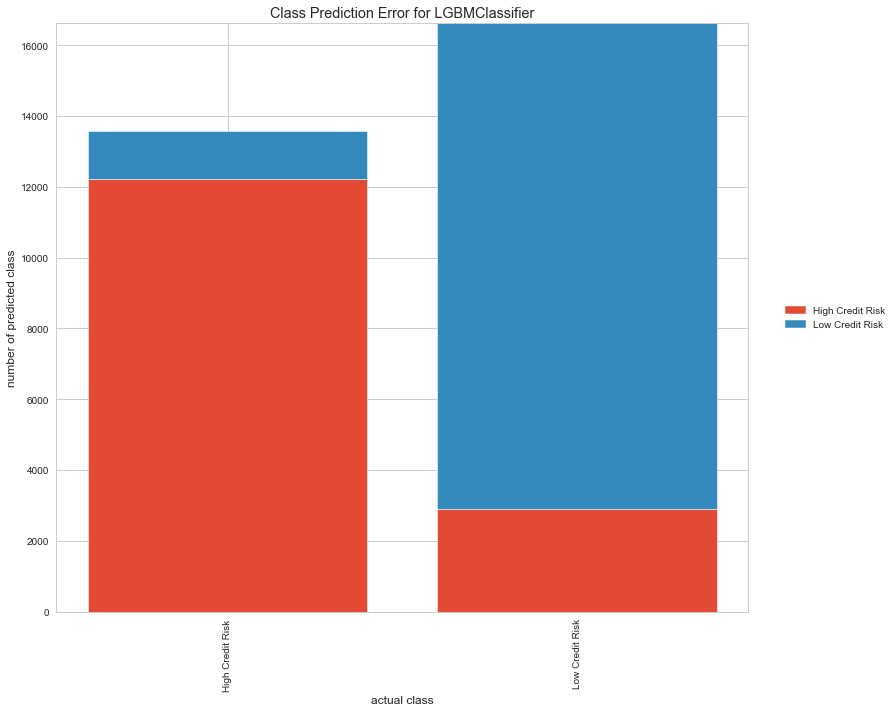

<AxesSubplot:title={'center':'Class Prediction Error for LGBMClassifier'}, xlabel='actual class', ylabel='number of predicted class'>

In [20]:
# Visualizing prediction error

from yellowbrick.classifier import class_prediction_error

plt.figure(figsize = (14,10))
sns.set_style("whitegrid")
viz = class_prediction_error(
    lgb_sm,
    trainX_SM, trainY_SM.values.ravel(),
    testX_SM, testY_SM.values.ravel(),
    classes=['High Credit Risk', 'Low Credit Risk'])

viz.show()

## Making predictions on the 2018 data

In [35]:
# Loading 2018 Predictions dataset
auto_potential_2018 = pd.read_csv("auto_potential_customers_2018.csv")

# Renaming columns
auto_potential_2018.columns = auto_potential_2018.columns.str.replace("agecat","age_category")
auto_potential_2018.columns = auto_potential_2018.columns.str.replace("veh_age","vehicle_age")
auto_potential_2018.columns = auto_potential_2018.columns.str.replace("veh_body","vehicle_body")
auto_potential_2018.columns = auto_potential_2018.columns.str.replace("veh_value","vehicle_value")

# Creating new features
new_feat_2018(auto_potential_2018)

# NA replace
na_replace(auto_potential_2018)

#Dropping columns and outliers
auto_potential_2018.drop(['date_of_birth'], axis=1, inplace=True)
auto_potential_2018 = auto_potential_2018.drop(auto_potential_2018.index[[146, 5448]])
auto_potential_2018.drop(['quote_number'], axis=1, inplace=True)

# Robust scaling data
rb_scale_cols(test_df)

# Making predictions and storing in a df
pred_2018 = lgb_sm.predict(test_df)
pred_2018 = pd.DataFrame(pred_2018)
pred_2018.columns = ['claim_risk_cat']

# Merging with original table
auto_potential_2018_full = pd.concat([auto_potential_2018, pred_2018],axis=1,ignore_index=True)
auto_potential_2018_full = auto_potential_2018_full.dropna()

### I will use this data to figure out the potential high and low risk customers

In [38]:
# auto_potential_2018_full